# Domain decomposition in 2D

In this notebook we show how to apply the `DomDecOT` library to a transport problem where the measures live in 2D rectangles. The objective is to obtain a solution with small regularization and small PD gap. 

In [1]:
import Pkg; Pkg.activate("."); Pkg.instantiate() # Activate environment

  Activating environment at `~/PhD/DomDec/DomDecOTExamples.jl/Project.toml`


In [2]:
using DomDecOT
using MultiScaleOT
import MultiScaleOT: normalize!
using MAT
using Plots
using SparseArrays
default(size = (400, 400), legend = :none, aspect_ratio = :equal, ticks = false, showaxis = false)
import Logging

# Downsample an image to size (Nx, Ny)(if size(img) divisible by (Nx, Ny))
# and flatten the result to a vector
function downsample_and_flatten(img, Nx, Ny; normalize = true)
    (size(img) .% (Nx, Ny) == (0,0)) || error("new size (Nx, Ny) not compatible with size(img)")
    s = size(img)
    μ = reshape(sum(reshape(img, s[1]÷Nx, Nx, s[2]÷Ny, Ny), dims = (1,3)), :)
    if normalize
        normalize!(μ)
    end
    return μ
end

downsample_and_flatten (generic function with 1 method)

Load 2048x20148 images from file, downsample to NxN and transform it into a `GridMeasure`s living on grids with space between nodes = 1.

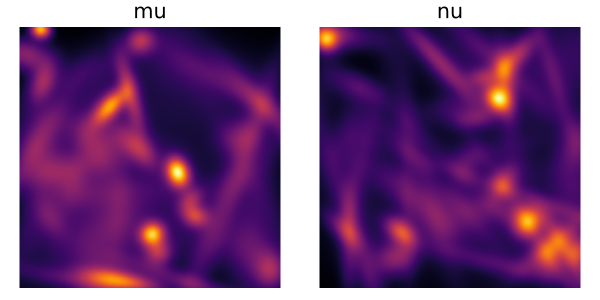

In [3]:
# Loading data
fn2 = "g-009-2048.mat"
μ0 = matread("data/g-008-2048.mat")["a"] # img 2048 x 2048

N = 256 # of the form 2^n
μ = downsample_and_flatten(μ0, N, N; normalize = true)
x1 = collect(1:N)
X = flat_grid(x1, x1)
shapeX = (N, N)

ν0 = matread("data/g-009-2048.mat")["a"] # img 2048 x 2048
ν = downsample_and_flatten(ν0, N, N; normalize = true)
Y = copy(X)
shapeY = (N, N)

mu = GridMeasure(X, μ, shapeX)
nu = GridMeasure(Y, ν, shapeY)
plot(
    heatmap(reshape(mu.weights, mu.gridshape...), title = "mu"),
    heatmap(reshape(nu.weights, nu.gridshape...), title = "nu"),
    size = (600,300)
)

Transform the target measures into MultiScaleMeasure to use a coarse-to-fine algorithm.

In [4]:
muH = MultiScaleMeasure(mu)
nuH = MultiScaleMeasure(nu)

MultiScaleMeasure with depth 9.
Finest level given by 2D GridMeasure with gridshape (256, 256)

The objective of this cell is to provide a schedule of the parameters to use in the domain decomposition algorithm. `params_schedule` can be seen as dataframe, with the number of rows being the number of steps in the algorithm, and the number of columns being the number of parameters. Each column yields the history of each parameter, and each row the list of all parameters to be used at a given step. The helper function `default_domdec_eps_schedule` provides the refinement schedule for $\varepsilon$ explained in Section 7.1, _Multi-scale and ε-scaling_ of https://arxiv.org/abs/2001.10986.

The parameters are organized into tuples since this allows the iterations to be type-stable.

In [5]:
depth = muH.depth

# Epsilon schedule
Nsteps = 3
factor = 2.
eps_target = 0.5
last_iter = [eps_target/2]

layer_schedule, eps_schedule, iters_schedule = default_domdec_eps_schedule(depth, eps_target; 
                                                                        Nsteps, factor, last_iter)
parallel_iteration = true

params_schedule = make_domdec_schedule(
                    layer = layer_schedule,
                    epsilon = eps_schedule, 
                    solver_max_error = 1e-4,
                    solver_max_error_rel=true, 
                    solver_max_iter = 10000, 
                    solver_verbose = true,
                    balance = true,
                    truncate = true,
                    truncate_Ythresh = 1e-15, 
                    truncate_Ythresh_rel = false, 
                    parallel_iteration = parallel_iteration,
                    domdec_iters = iters_schedule
            );

# Visualize parameters for last step of the algorithm
params_schedule[end]

(epsilon = 0.25, solver_max_error = 0.0001, solver_max_error_rel = true, solver_max_iter = 10000, solver_verbose = true, solver_truncation = 1.0e-15, balance = true, truncate = true, truncate_Ythresh = 1.0e-15, truncate_Ythresh_rel = false, parallel_iteration = true, layer = 9, domdec_iters = 2)

Set initialization of the domain decomposition algorithm.

In [6]:
# Starting layer
layer0 = 4

# Measures at the coarsest level
mu0 = muH[layer0]
nu0 = nuH[layer0]

# Size of basic cells
cellsize = 4

# Initial plan at the finest level
π0 = sparse(nu0.weights .* mu0.weights')

# l22 is oour non-allocating version of the squared cost (l22(x,y) = norm(x-y)^2)
c(x,y) = l22(x, y)

# Some other solvers are available (see https://ismedina.github.io/DomDecOT.jl/dev/library/#Solvers),
# and custom ones can be coded
solver = domdec_sinkhorn_autofix_log!

# Find row of params for the first iteration
k0 = findfirst(params_schedule.layer .== layer0)
# Initialize initial DomDecPlan
P0 = DomDecPlan(mu0, nu0, π0, cellsize)

DomDecPlan with cellsize 4 and marginals
    mu: 2D GridMeasure with gridshape (8, 8)
    nu: 2D GridMeasure with gridshape (8, 8)

The iteration is encoded into the function `iterate!`, which takes plan, cost, solver and params (a named tuple). From params he takes all the arguments he needs (`:solver_...` are passed to the solver, `parallel_iteration` is used to check if a parallelized iteration is desired, and so on). It modifies the plan `P` inplace. Here's how it works:

In [7]:
# precompile iterate! and refine_plan
P = deepcopy(P0)
iterate!(P, c, solver, params_schedule[k0])
P

DomDecPlan with cellsize 4 and marginals
    mu: 2D GridMeasure with gridshape (8, 8)
    nu: 2D GridMeasure with gridshape (8, 8)

After the determined number of iterations in one layer, we refine the plan to the next one by using `refine_plan`:

In [8]:
P = refine_plan(P0, muH, nuH, layer0+1)

DomDecPlan with cellsize 4 and marginals
    mu: 2D GridMeasure with gridshape (16, 16)
    nu: 2D GridMeasure with gridshape (16, 16)

The following is a working example of the rest of the workflow. Solving and refinement times are printed. To really see good performance you should set `parallel_iteration = true` in the definition of `params_schedule`, as well as starting Julia with a number of threads (for 5 threads launch it with `julia -t 5`). 

In [9]:
save_plans = N ≤ 256 # for large plans we should save them to the disk
compute_PD_gap = true

nthreads = (parallel_iteration ? Threads.nthreads() : 1)
println("Running on ", nthreads, " threads\n")    

P = deepcopy(P0)
if compute_PD_gap
    println("Layer\tepsilon\ttime\tRelative PD gap")
else
    println("Layer\tepsilon\ttime")
end

if save_plans 
    plans = []
end

times = Dict(:solve => 0.0, :refine => 0.0) # Keep track of the elapsed time
for k in k0:length(params_schedule)
    # Get parameters
    params = params_schedule[k]
    i = params.layer

    t0 = time()
    iterate!(P, c, solver, params)
    times[:solve] += time() - t0
    
    print(i,"\t",params.epsilon,"\t",round(times[:solve]+times[:refine], digits = 2))
    
    if compute_PD_gap
        score1, score2 = DomDecOT.primal_and_dual_score(P, c, P.epsilon)
        print("\t",(score1-score2)/score1 )
    end
    if save_plans
        push!(plans, (i, k, deepcopy(P)))
    end
    println()
    
    # Refine
    if (i < depth) && (i != params_schedule.layer[k+1])
        t0 = time()
        # global is needed when running this notebook as a script
        global P = refine_plan(P, muH, nuH, i+1; consistency_check = false) 
        times[:refine] += time() - t0
        println("   Refinement\t",round(times[:solve]+times[:refine], digits = 2))
    end
end

println("\nSolve time\t",times[:solve])
println("Refine time\t", times[:refine])
println("Total time\t", times[:solve]+times[:refine])

Running on 4 threads

Layer	epsilon	time	Relative PD gap
4	2048.0	0.02	5.074421941762391e-9
4	1024.0	0.02	7.374437151342383e-6
4	512.0	0.02	4.525732403605102e-5
   Refinement	0.02
5	512.0	0.03	5.542357508784654e-5
5	256.0	0.03	0.0003375006236296447
5	128.0	0.04	4.8718178941678454e-5
   Refinement	0.04
6	128.0	0.09	3.520403875018005e-5
6	64.0	0.12	0.000259428548984769
6	32.0	0.14	5.5416832233398054e-5
   Refinement	0.14
7	32.0	0.42	1.8323185311476637e-5
7	16.0	0.5	0.00010602944714165368
7	8.0	0.59	3.644074857654821e-5
   Refinement	0.63
8	8.0	1.44	1.2302940395821364e-5
8	4.0	1.81	3.8691644585354764e-5
8	2.0	2.12	1.975450418816299e-5
   Refinement	2.2
9	2.0	5.54	1.1453937256147674e-5
9	1.0	6.97	1.9990773596582477e-5
9	0.5	8.21	1.9053581739613535e-5
9	0.25	9.77	4.3893158555540565e-5

Solve time	9.642619848251343
Refine time	0.1314380168914795
Total time	9.774057865142822


Conver the solution to a sparse matrix and check the `l1` distance between marginals.

In [10]:
K = plan_to_sparse_matrix(P, c)
# Check marginals
l1(sum(K, dims = 1), muH[end].weights), l1(sum(K, dims = 2), nuH[end].weights)

(1.4321798855666432e-10, 1.3751700315545501e-10)

In [11]:
# Number of non-zero entries / non-zero entries in mu
sum(length.(getproperty.(P.gamma, :nzind)))/length(muH[end].weights)

3.2158203125

Visualize the final coupling as in Section 7.2 of https://arxiv.org/abs/2001.10986: show the region where $i$-th basic cell of each composite cell maps to with the same color (note how the image of a basic cell is larger where there is low density in nu).

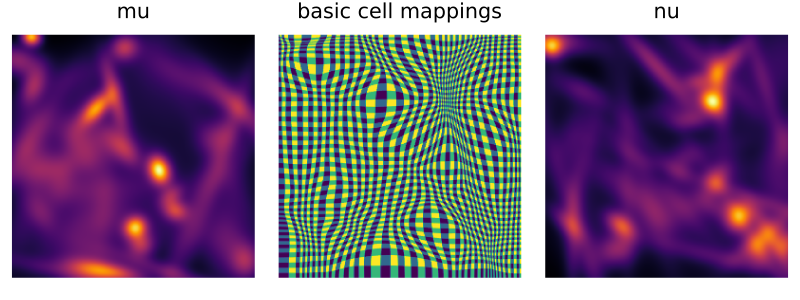

In [12]:
function distortion_map(P)
    A = zeros(prod(P.nu.gridshape))
    for J in P.composite_cells[1]
        for (i,j) in enumerate(J)
            νi = P.gamma[j]
            A[νi.nzind] .+= i.*νi.nzval
        end
    end
    A ./= P.nu.weights
    return reshape(A, P.nu.gridshape)
end

_, _, P = plans[end]
p1 = heatmap(reshape(muH[end].weights, muH[end].gridshape...),ticks = false, title = "mu")
p2 = heatmap(distortion_map(P), size = (400,400), color = :viridis, 
                title = "basic cell mappings", ticks = false)
p3 = heatmap(reshape(nuH[end].weights, nuH[end].gridshape...),ticks = false, title = "nu")
plot(p1, p2, p3, size = (800, 300), layout = (1,3))

Visualize final coupling in each layer with the same method. Note the small blur, approximately of one pixel of width.

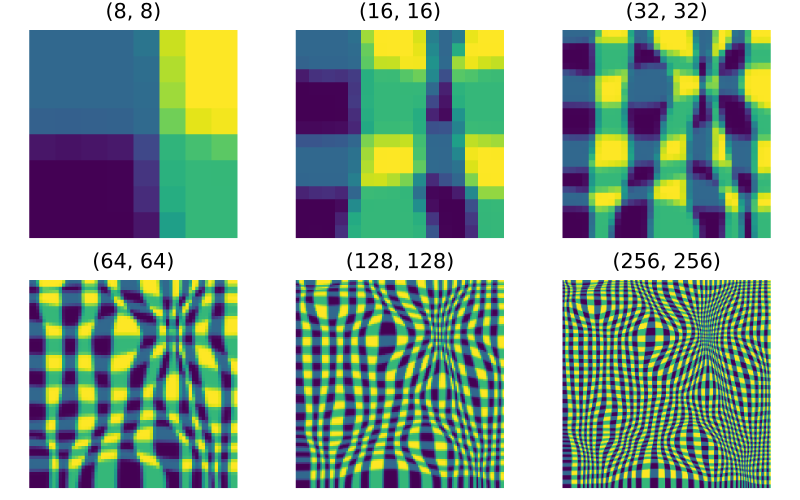

In [13]:
if save_plans
    plots = []
    for j in layer0:depth        
        j = findlast(x -> plans[x][1] == j, 1:length(plans))
        _, _, P = plans[j]
        pi = heatmap(distortion_map(P), size = (600,600), color = :viridis, 
                    title = "$(P.mu.gridshape)", ticks = false)
        push!(plots, pi)
    end
    plot(plots..., layout = (2, 3), size = (800, 500))
    #savefig("distortion_map.png")
end
plot!()

Last, visualize the whole process as a gif

In [14]:
if save_plans
    anim = @animate for i in eachindex(plans)
        j,_, P = plans[i]
        k = i + 1 - findfirst(k->plans[k][1]==j, eachindex(plans))
        plot(
            #heatmap(reshape(muH[j].weights, muH[j].gridshape...),ticks = false, title = "mu"),
            heatmap(distortion_map(P), size = (400,400), color = :viridis, 
                title = "$(P.mu.gridshape), step $k", ticks = false),
            #heatmap(reshape(nuH[j].weights, nuH[j].gridshape...),ticks = false, title = "nu"),
            size = (400, 400), layout = (1,1)
        )
    end
end

Animation("/tmp/jl_O70Glq", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png", "000011.png", "000012.png", "000013.png", "000014.png", "000015.png", "000016.png", "000017.png", "000018.png", "000019.png"])

Plots.AnimatedGif("/home/ismael/PhD/DomDec/DomDecOTExamples.jl/tmp.gif")
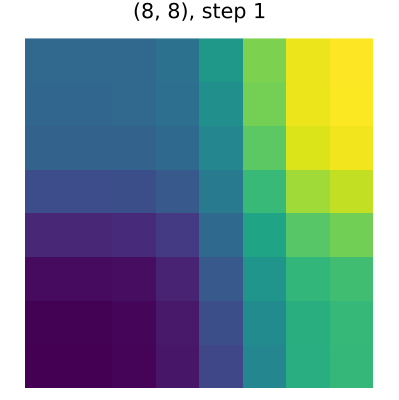

In [15]:
Logging.disable_logging(Logging.Info) # For privacy reasons
gif(anim, fps = 1)